# Text Classification of News Articles Using Neural Networks: A Case Study on AG News Dataset


Link to dataset: https://huggingface.co/datasets/fancyzhx/ag_news

### Import Necessary Libraries


In [ ]:
%pip install emoji
import emoji
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import re
import seaborn as sns
import string
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
# Using NLTK
import nltk
'''nltk.download('punkt_tab')
nltk.download('punkt')
#
#!pip install fasttext
#!pip install gensim

'''
from nltk.tokenize import word_tokenize
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling1D, MaxPooling1D, Input, Embedding, Flatten, Conv1D, Dense, Dropout, Bidirectional, LSTM
import tensorflow as tf
np.random.seed(70)
tf.random.set_seed(70)


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Step 1: Load Dataset

In [ ]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
train_df= pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["train"])
test_df = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["test"])
merged_df = pd.concat([train_df,test_df], axis = 0)
#these are the labels for our news category
labels =["World","Sports","Business","Sci/Tech"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print(train_df.shape)
print(test_df.shape)

(120000, 2)
(7600, 2)


## Step 2: Exploratory Data Analysis

Let us examine our data properties before we clean and process it.

In [ ]:
#Explore the properties of data
print(merged_df.shape)
print(merged_df.info())
merged_df.head()

(127600, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 127600 entries, 0 to 7599
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    127600 non-null  object
 1   label   127600 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ MB
None


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [ ]:
merged_df.label.value_counts()

,count
label,
2,31900
3,31900
1,31900
0,31900


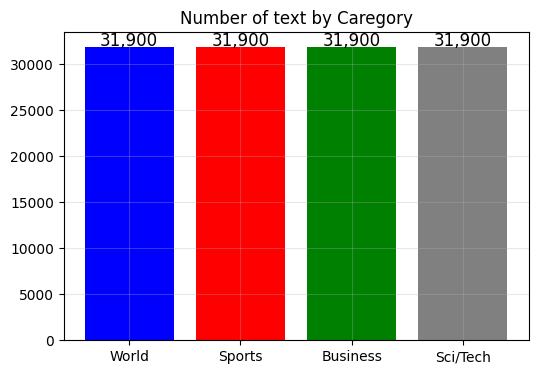

In [ ]:
# Let us examine the number of news by category

val_co =merged_df["label"].value_counts()
plt.figure(figsize= (6,4))
plt.bar(val_co.index, val_co.values, color =["green","grey","red","blue"])
plt.title("Number of text by Caregory")
for position, val in enumerate(val_co.values):
    plt.text(position, val+100, f"{val:,}", ha ='center', fontsize = 12)
plt.grid(alpha = 0.3)
plt.xticks(range(len(labels)), labels)  # Rotate for better visibility

plt.show()


In [ ]:
#Visualizations of news

all_news = " ".join((merged_df["text"]))
world_news = ' '.join(merged_df[merged_df["label"]==0]["text"])
sport_news = ' '.join(merged_df[merged_df["label"]==1]["text"])
business_news = ' '.join(merged_df[merged_df["label"]==2]["text"])
tech_news = ' '.join(merged_df[merged_df["label"]==3]["text"])

In [ ]:
len(world_news)

7767439

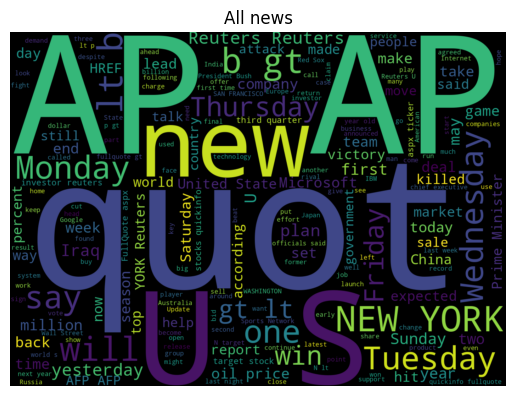

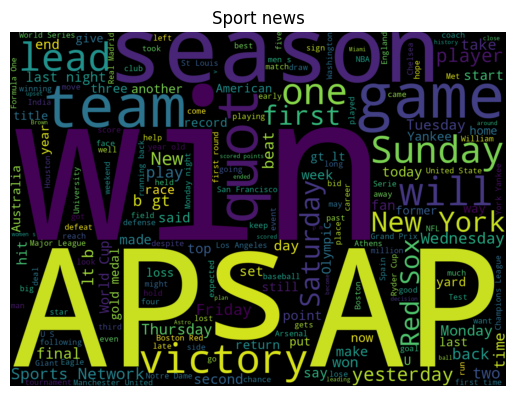

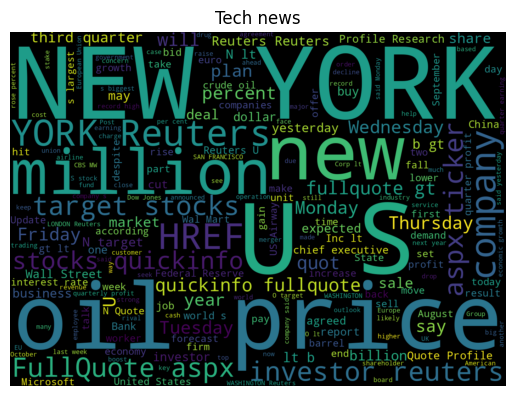

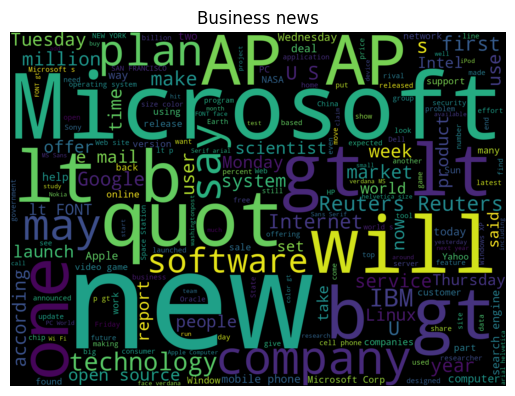

In [ ]:
#wordcloud for all news
def plot_wordcloud(news_str, title= 'News Word Cloud'):
    wc = WordCloud(width = 1400, height = 1000).generate(news_str)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_wordcloud(all_news, title= 'All news')
plot_wordcloud(sport_news, title= 'Sport news')
plot_wordcloud(business_news, title= 'Tech news')
plot_wordcloud(tech_news, title= 'Business news')

## Step 3: Data Cleaning

In [ ]:
merged_df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [ ]:
#Check for null entries
print("Null entries: ")
print(merged_df.isna().sum())
print()

#Check  for duplicate entries
print("Duplicate entries: ")
print(merged_df.duplicated().sum())



Null entries: 
text     0
label    0
dtype: int64

Duplicate entries: 
0


## Step 4: Data Preprocessing

Before we can pass our data into the deep learning models, we must firstly preprocess the news, and extract features that our models can understand. The steps I will be taking are:
1. convert all text to lower case
2. Remove URLs
3. Remove of hastags
4. Remove punctuation
5. Remove Stopwords
6. Tokenize

In [ ]:
import nltk #data cleaning
nltk.download('punkt_tab')
#nltk.download('punkt')

from nltk.tokenize import word_tokenize

#function to automate the cleaning of news
def clean_news(news):
    news = news.lower()    # Convert text to lowercase
    news = re.sub(r'https?://\S+|www\.\S+', '', news)# Remove urls (Http(s) and www)
    news=  re.sub(r'#', "", news) # Remove hastags
    news = emoji.replace_emoji(news,"")# Remove emojis
    news = re.sub(r'[0-9]+',"", news)# Removes numbers
    news = re.sub(r'\s+'," ", news)    #remove extra spaces
    #Tokenize news
    tokens = word_tokenize(news)
    clean_tokens = [] # container tokens without punctuations
    for word in tokens:
        if(word not in (string.punctuation)):
            clean_tokens.append((word))
    return clean_tokens


#This code shows the cleaning of a random news
example = ("@Donald Trump Wins The #US election reports banji #US")
test_clean = clean_news(example)
print("Cleaned example:")
print(" ".join(test_clean))

Cleaned example:
donald trump wins the us election reports banji us


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
#Preprocessing
#Firstly clean the news
#list of clean individual words
merged_df["clean_news"] = merged_df["text"].apply(clean_news)
merged_df.head()


,text,label,clean_news
0,Wall St. Bears Claw Back Into the Black (Reute...,2,"[wall, st., bears, claw, back, into, the, blac..."
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,"[carlyle, looks, toward, commercial, aerospace..."
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,"[oil, and, economy, cloud, stocks, outlook, re..."
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,"[iraq, halts, oil, exports, from, main, southe..."
4,"Oil prices soar to all-time record, posing new...",2,"[oil, prices, soar, to, all-time, record, posi..."


In [ ]:
#now we join the clean news
merged_df["clean_news"] = merged_df["clean_news"].apply(lambda words: " ".join(words))
merged_df[["clean_news"]]

,clean_news
0,wall st. bears claw back into the black reuter...
1,carlyle looks toward commercial aerospace reut...
2,oil and economy cloud stocks outlook reuters r...
3,iraq halts oil exports from main southern pipe...
4,oil prices soar to all-time record posing new ...
...,...
7595,around the world ukrainian presidential candid...
7596,void is filled with clement with the supply of...
7597,martinez leaves bitter like roger clemens did ...
7598,of arthritis patients in singapore take bextra...


In [ ]:
merged_df

,text,label,clean_news
0,Wall St. Bears Claw Back Into the Black (Reute...,2,wall st. bears claw back into the black reuter...
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,carlyle looks toward commercial aerospace reut...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,oil and economy cloud stocks outlook reuters r...
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,iraq halts oil exports from main southern pipe...
4,"Oil prices soar to all-time record, posing new...",2,oil prices soar to all-time record posing new ...
...,...,...,...
7595,Around the world Ukrainian presidential candid...,0,around the world ukrainian presidential candid...
7596,Void is filled with Clement With the supply of...,1,void is filled with clement with the supply of...
7597,Martinez leaves bitter Like Roger Clemens did ...,1,martinez leaves bitter like roger clemens did ...
7598,5 of arthritis patients in Singapore take Bext...,2,of arthritis patients in singapore take bextra...


## Step 5: Feature Extratction


In [ ]:
# we will split our data back into X_train and X_test

train_df = merged_df[:120000]
test_df = merged_df[120000:]

print(train_df.shape)
print(test_df.shape)

(120000, 3)
(7600, 3)


In [ ]:
X_train = train_df["clean_news"]
X_test = test_df["clean_news"]

y_train = train_df["label"]
y_test = test_df["label"]

In [ ]:
X_train = [''.join(news) for news in X_train]
X_test = [''.join(news) for news in X_test]
X_train[:2]

["wall st. bears claw back into the black reuters reuters short-sellers wall street 's dwindling\\band of ultra-cynics are seeing green again",
 'carlyle looks toward commercial aerospace reuters reuters private investment firm carlyle group \\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry has quietly placed\\its bets on another part of the market']

In [ ]:
# The TextVectorization layer converts our raw text into sequences of integers
# This also handles the padding we are using zero padding
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=80  #max_sequence=80
)

#We will build our vocabulary on only the train data
vectorizer.adapt(X_train)

In [ ]:
# We are actually transforming your data split into numeric sequences
X_train = vectorizer(X_train).numpy()
X_test = vectorizer(X_test).numpy()
print(X_train.shape)
print(X_test.shape)

(120000, 80)
(7600, 80)


In [ ]:
X_train[20000]

array([8586,  960, 2118,    4, 5798,   41, 1243,   30,  605,  371,   10,
          1,    1,    3, 3993,    6,   27,   41,  183,  162,  270, 2205,
          1,   78,   25, 6056, 1380,    6,    4, 4306,   41, 1243,    7,
       1070,    4, 7422, 1805,  102,    1,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [ ]:
# the first 20 words in the vocabulary[UNK] is used to represent unknown
# or out of vocabulary (OOV) words in the embedding layer.
#vocab_size: this is the vocab size incase I change it
vocab = vectorizer.get_vocabulary()
print(vocab[:20])
vocab_size = len(vocab)

['', '[UNK]', 'the', 'to', 'a', 'of', 'in', 'and', 'on', 's', 'for', 'that', 'with', 'as', 'at', 'is', 'its', 'new', 'by', 'it']


## Step 6: Application of Deep Learning Algorithms
The last step for sentiment analysis is the application of machine learing or deep learning model. For this course work I will be using five machine learning models for this classification problem


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

### 6.1 Functions to compile and evaluate models

In [ ]:
def compile_model(model):
    """
    This will compile all our models
    """
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

def train_model(compiled_model, epochs=10, batch_size=32):
    """
    This will take our compiled model and train it
    """
    history = compiled_model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )
    return history


def evaluate_model(trained_model):
    """
    Evaluate our trained model on test data
    """
    results = trained_model.evaluate(X_test, y_test)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    return results


def model_predict(trained_model, model_name):
    """
    This will make predictions on the test data and give us the classification report

    parameters
    ----------
    - trained_model: already trained model
    - model_name: should be the name of the model (string)
    """
    y_pred_probabilities = trained_model.predict(X_test)
    y_pred = np.argmax(y_pred_probabilities, axis=1)

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

def plot_confusion(trained_model, model_name):
    # Plot confusion matrix
    y_pred_probabilities = trained_model.predict(X_test)
    y_pred = np.argmax(y_pred_probabilities, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.savefig(f"{model_name}_confusion_matrix.png",bbox_inches='tight')
    plt.show()


def plot_training_history(history, model_name):
    """
    Plot training & validation accuracy and loss with model name

    Parameters:
    - history: Model training history
    - model_name: Name of the model (for title display)
    """
    plt.figure(figsize=(6, 5))

    # This will show accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Trainining Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig(f"{model_name}_accuracy_plot.png",bbox_inches='tight')

    # show loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(f"{model_name}_loss_plot.png",bbox_inches='tight')
    plt.show()


In [ ]:
#!pip install --force-reinstall gensim

### 6.2 Functions for all our four models

In [ ]:
def mlp_model(embedding_layer):
    """
    This will build our Multilayer perceptron model
    parameters:
    - embedding_layer: the type of embedding layers we will be using
    """
    model = Sequential([
        #input layer
        Input(shape=(80,)),
        embedding_layer,
        Flatten(),

        # First hidden layer
        Dense(128, activation='relu'),
        Dropout(0.5),

        # Second hidden layer
        Dense(64, activation='relu'),
        Dropout(0.5),

        # Output layer
        Dense(4, activation='softmax')
        ])
    return model

def cnn_model(embedding_layer, filters = 200, kernel_size = 5):
    """
    This will build our convolutional neural network

    parameters:
    - embedding_layer: the type of embedding layers we will be using
    - kernel_size
    - filters
    """
    model = Sequential([
        # Input Layer
        Input(shape=(80,)),

        # Embedding_layer
        embedding_layer,
        Conv1D(filters=filters,kernel_size= kernel_size, activation='relu'),
        Conv1D(filters=filters,kernel_size= kernel_size, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    return model

def BiLstm_model(embedding_layer):
    """
    This will build our bidirectional lstm

    parameters:
    - embedding_layer: the type of embedding layers we will be using
    - kernel_size
    - filters
    """


    model= Sequential([
        Input(shape=(80,)),
        embedding_layer,
        Bidirectional(LSTM(64, return_sequences=True)), #This is forwARD
        Bidirectional(LSTM(64)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    return model




def rnn_model(embedding_layer):
    """
    This will build our Recurrent Neural Network model
    parameters:
    - embedding_layer: the type of embedding layers we will be using
    """
    model = Sequential([
        Input(shape=(80,)),
        embedding_layer,
        SimpleRNN(128, return_sequences=True),
        SimpleRNN(64),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        # Output layer
        Dense(4, activation='softmax')
    ])
    return model


### 6.3 Load and Create Embedding Layers

In [ ]:
'''!pip install gensim
!pip install --force-reinstall gensim'''
import gensim.downloader as api
from gensim.models import KeyedVectors

In [ ]:
#embeddings
#Load glove embeddings
# 300 dimensions stanford
glove_vectors = api.load("glove-wiki-gigaword-300") #300 dimension by facebook
fasttext_vectors = api.load('fasttext-wiki-news-subwords-300')
# Load Word2Vec embeddings (Google News, 300D)
word2vec_vectors = api.load('word2vec-google-news-300')  # 300-dimensional

[==================================================] 100.0% 376.1/376.1MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded
[==================================================] 100.0% 1662.8/1662.8MB downloaded


#### 6.3.1 Creation of Embedding Layers

In [ ]:
 #1
random_embedding_layer = Embedding(
    input_dim=vocab_size, #this is 80
    output_dim= 300 #we are now using 300
    )


# Initialize with zeros
glove_embedding_matrix = np.zeros((vocab_size, 300))

#create a dictionary mapping words to indices
word_index = dict(zip(vocab, range(len(vocab))))

for word, index in word_index.items():
    if word in glove_vectors:
        glove_embedding_matrix[index] = glove_vectors[word]
    else:
        # we'll use random numbers for words we not in embedding  initialization)
        glove_embedding_matrix[index] = np.random.uniform(-0.25, 0.25, 300)
#2
glove_embedding_layer = Embedding(
       input_dim=vocab_size,
       output_dim=300,  #embedding_dim, 300 for glove
       weights=[glove_embedding_matrix],  # Use pre-trained weights
       trainable=True  # makes it trainable
   )



# Create the embedding matrix
# embedding dim here is also 300
fasttext_embedding_matrix = np.zeros((vocab_size, 300))
# Create a dictionary mapping words to indices
word_index = dict(zip(vocab, range(len(vocab))))

for word, index in word_index.items():
    if word in fasttext_vectors:
        fasttext_embedding_matrix[index] = fasttext_vectors[word]
    else:
        #similarl random for words not in vocab
        fasttext_embedding_matrix[index] = np.random.uniform(-0.25, 0.25, 300)

fasttext_embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=300,
    weights=[fasttext_embedding_matrix],
    trainable=True)



word2vec_embedding_matrix = np.zeros((vocab_size, 300))
word_index = dict(zip(vocab, range(len(vocab))))

for word, index in word_index.items():
    if word in word2vec_vectors:
        word2vec_embedding_matrix[index] = word2vec_vectors[word]
    else:

        word2vec_embedding_matrix[index] = np.random.uniform(-0.25, 0.25, 300)

word2vec_embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=300,
    weights=[word2vec_embedding_matrix],
    trainable=True ) # Fine-tune embeddings during training)


### 6.4 Create Models With Different Embeddings

In [ ]:
# MLP with different embeddings
mlp_random = mlp_model(random_embedding_layer)
mlp_glove = mlp_model(glove_embedding_layer)
mlp_fasttext = mlp_model(fasttext_embedding_layer)
mlp_word2vec = mlp_model(word2vec_embedding_layer)



In [ ]:
# CNN with different embeddings
cnn_random = cnn_model(random_embedding_layer)
cnn_glove = cnn_model(glove_embedding_layer)
cnn_fasttext = cnn_model(fasttext_embedding_layer)
cnn_word2vec = cnn_model(word2vec_embedding_layer)

In [ ]:
# BiLSTM with different embeddings

BiLstm_random = BiLstm_model(random_embedding_layer)
BiLstm_glove = BiLstm_model(glove_embedding_layer)
BiLstm_fasttext = BiLstm_model(fasttext_embedding_layer)
BiLstm_word2vec = BiLstm_model(word2vec_embedding_layer)

In [ ]:
# RNN with different embeddings
rnn_random = BiLstm_model(random_embedding_layer)
rnn_glove = BiLstm_model(glove_embedding_layer)
rnn_fasttext = BiLstm_model(fasttext_embedding_layer)
rnn_word2vec = BiLstm_model(word2vec_embedding_layer)

### 6.5 Compile and Train Models


#### 6.5.1 Models with Randomly Initiated Word Embeddings

In [ ]:
#MLP
compile_model(mlp_random)
history_mlp_random = train_model(mlp_random)
evaluate_model(mlp_random)
model_predict(mlp_random, model_name="MLP Random")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 24000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,072,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,080,644 (23.20 MB)

 Trainable params: 6,080,644 (23.20 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.7664 - loss: 0.5818 - val_accuracy: 0.9076 - val_loss: 0.2728
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.9269 - loss: 0.2280 - val_accuracy: 0.9029 - val_loss: 0.3090
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9546 - loss: 0.1352 - val_accuracy: 0.8992 - val_loss: 0.4551
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9755 - loss: 0.0754 - val_accuracy: 0.8924 - val_loss: 0.5613
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9079 - loss: 0.2828
Test Loss: 0.2728
Test Accuracy: 0.9076
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

MLP Random Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1900
           1       0.94      0.99      0.96      1900
           2       0.90      0.84      0.87      1900
           3       0.85      0.93      0.88      1900

    accu

In [ ]:
#2 CNN
compile_model(cnn_random)
history_cnn_random = train_model(cnn_random)
evaluate_model(cnn_random)
model_predict(cnn_random, model_name="CNN Random")



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 76, 200)        │       300,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 72, 200)        │       200,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 200)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,526,644 (13.45 MB)

 Trainable params: 3,526,644 (13.45 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.8967 - loss: 0.3232 - val_accuracy: 0.9091 - val_loss: 0.2749
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.9257 - loss: 0.2238 - val_accuracy: 0.9078 - val_loss: 0.2884
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9421 - loss: 0.1678 - val_accuracy: 0.9045 - val_loss: 0.3646
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9554 - loss: 0.1258 - val_accuracy: 0.9014 - val_loss: 0.4232
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9059 - loss: 0.2878
Test Loss: 0.2749
Test Accuracy: 0.9091
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

CNN Random Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1900
           1       0.95      0.98      0.96      1900
           2       0.85      0.89      0.87      1900
           3       0.88      0.90      0.89      1900

    accu

In [ ]:
#3 Bidirectional LSTM
compile_model(BiLstm_random)
history_BiLstm_random  = train_model(BiLstm_random)
evaluate_model(BiLstm_random )
model_predict(BiLstm_random , model_name="BiLSTM Random")



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 80, 128)        │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,294,212 (12.57 MB)

 Trainable params: 3,294,212 (12.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 72s 18ms/step - accuracy: 0.8978 - loss: 0.3285 - val_accuracy: 0.9089 - val_loss: 0.2822
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 66s 18ms/step - accuracy: 0.9349 - loss: 0.2117 - val_accuracy: 0.9082 - val_loss: 0.3029
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.9499 - loss: 0.1570 - val_accuracy: 0.9058 - val_loss: 0.3382
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 85s 18ms/step - accuracy: 0.9614 - loss: 0.1178 - val_accuracy: 0.9058 - val_loss: 0.4380
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9043 - loss: 0.3005
Test Loss: 0.2822
Test Accuracy: 0.9089
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

BiLSTM Random Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91      1900
           1       0.95      0.98      0.97      1900
           2       0.84      0.92      0.88      1900
           3       0.91      0.86      0.88      1900

 

In [ ]:
#4 RNN
compile_model(rnn_random)
history_rnn_random  = train_model(rnn_random)
evaluate_model(rnn_random )
model_predict(rnn_random , model_name="RNN Random")


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 80, 128)        │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,294,212 (12.57 MB)

 Trainable params: 3,294,212 (12.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 70s 18ms/step - accuracy: 0.9129 - loss: 0.2891 - val_accuracy: 0.9057 - val_loss: 0.3034
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 67s 18ms/step - accuracy: 0.9399 - loss: 0.1974 - val_accuracy: 0.9054 - val_loss: 0.3398
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.9529 - loss: 0.1513 - val_accuracy: 0.9034 - val_loss: 0.3665
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.9625 - loss: 0.1191 - val_accuracy: 0.9011 - val_loss: 0.4383
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9032 - loss: 0.3233
Test Loss: 0.3034
Test Accuracy: 0.9057
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

RNN Random Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1900
           1       0.95      0.98      0.96      1900
           2       0.87      0.87      0.87      1900
           3       0.87      0.89      0.88      1900

   

#### 6.5.2 Models with Glove Embeddings

In [ ]:
#MLP
compile_model(mlp_glove)
history_mlp_glove = train_model(mlp_glove)
evaluate_model(mlp_glove)
model_predict(mlp_glove, model_name="MLP glove")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 24000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,072,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,080,644 (23.20 MB)

 Trainable params: 6,080,644 (23.20 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.7236 - loss: 0.7524 - val_accuracy: 0.9026 - val_loss: 0.2967
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9000 - loss: 0.3230 - val_accuracy: 0.9101 - val_loss: 0.2757
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9212 - loss: 0.2582 - val_accuracy: 0.9093 - val_loss: 0.2807
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9362 - loss: 0.2091 - val_accuracy: 0.9076 - val_loss: 0.3067
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9499 - loss: 0.1672 - val_accuracy: 0.9078 - val_loss: 0.3650
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9114 - loss: 0.2885
Test Loss: 0.2757
Test Accuracy: 0.9101
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

MLP glove Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1900
           1       0.95      0.98      0.

In [ ]:
#2 CNN
compile_model(cnn_glove)
history_cnn_glove = train_model(cnn_glove)
evaluate_model(cnn_glove)
model_predict(cnn_glove, model_name="CNN glove")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 76, 200)        │       300,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 72, 200)        │       200,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 200)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,526,644 (13.45 MB)

 Trainable params: 3,526,644 (13.45 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.8967 - loss: 0.3196 - val_accuracy: 0.9126 - val_loss: 0.2597
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.9272 - loss: 0.2212 - val_accuracy: 0.9153 - val_loss: 0.2569
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9417 - loss: 0.1707 - val_accuracy: 0.9155 - val_loss: 0.2997
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9541 - loss: 0.1269 - val_accuracy: 0.9116 - val_loss: 0.3347
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9653 - loss: 0.0937 - val_accuracy: 0.9101 - val_loss: 0.4728
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9135 - loss: 0.2639
Test Loss: 0.2569
Test Accuracy: 0.9153
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

CNN glove Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      1900
           1       0.95      0.99      0.

In [ ]:
#3 Bidirectional LSTM
compile_model(BiLstm_glove)
history_BiLstm_glove  = train_model(BiLstm_glove)
evaluate_model(BiLstm_glove )
model_predict(BiLstm_glove , model_name="BiLSTM glove")

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 80, 128)        │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,294,212 (12.57 MB)

 Trainable params: 3,294,212 (12.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 78s 20ms/step - accuracy: 0.9007 - loss: 0.3217 - val_accuracy: 0.9166 - val_loss: 0.2543
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 70s 19ms/step - accuracy: 0.9363 - loss: 0.2021 - val_accuracy: 0.9167 - val_loss: 0.2670
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 69s 18ms/step - accuracy: 0.9475 - loss: 0.1587 - val_accuracy: 0.9203 - val_loss: 0.2818
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 86s 20ms/step - accuracy: 0.9579 - loss: 0.1209 - val_accuracy: 0.9171 - val_loss: 0.3228
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9146 - loss: 0.2664
Test Loss: 0.2543
Test Accuracy: 0.9166
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

BiLSTM glove Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      1900
           1       0.96      0.98      0.97      1900
           2       0.88      0.88      0.88      1900
           3       0.88      0.90      0.89      1900

  

In [ ]:
#4 RNN
compile_model(rnn_glove)
history_rnn_glove  = train_model(rnn_glove)
evaluate_model(rnn_glove)
model_predict(rnn_glove , model_name="RNN glove")


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 80, 128)        │       186,880 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,294,212 (12.57 MB)

 Trainable params: 3,294,212 (12.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 73s 18ms/step - accuracy: 0.9071 - loss: 0.3028 - val_accuracy: 0.9147 - val_loss: 0.2628
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.9381 - loss: 0.1954 - val_accuracy: 0.9175 - val_loss: 0.2938
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 69s 18ms/step - accuracy: 0.9500 - loss: 0.1508 - val_accuracy: 0.9109 - val_loss: 0.3286
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 84s 19ms/step - accuracy: 0.9598 - loss: 0.1181 - val_accuracy: 0.9134 - val_loss: 0.3764
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9121 - loss: 0.2730
Test Loss: 0.2628
Test Accuracy: 0.9147
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

RNN glove Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1900
           1       0.96      0.98      0.97      1900
           2       0.87      0.89      0.88      1900
           3       0.89      0.90      0.89      1900

    a

#### 6.5.3 Embeddings with fastText

In [ ]:
#MLP
compile_model(mlp_fasttext)
history_mlp_fasttext = train_model(mlp_fasttext)
evaluate_model(mlp_fasttext)
model_predict(mlp_fasttext, model_name="MLP fasttext")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 24000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,072,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,080,644 (23.20 MB)

 Trainable params: 6,080,644 (23.20 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.5596 - loss: 0.9402 - val_accuracy: 0.9021 - val_loss: 0.2845
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9137 - loss: 0.2754 - val_accuracy: 0.9051 - val_loss: 0.2925
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9416 - loss: 0.1797 - val_accuracy: 0.9026 - val_loss: 0.3776
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9661 - loss: 0.1033 - val_accuracy: 0.9020 - val_loss: 0.5174
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9008 - loss: 0.2988
Test Loss: 0.2845
Test Accuracy: 0.9021
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

MLP fasttext Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91      1900
           1       0.92      0.99      0.95      1900
           2       0.88      0.85      0.87      1900
           3       0.87      0.90      0.88      1900

    ac

In [ ]:
#2 CNN
compile_model(cnn_fasttext)
history_cnn_fasttext = train_model(cnn_fasttext)
evaluate_model(cnn_fasttext)
model_predict(cnn_fasttext, model_name="CNN fasttext")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 76, 200)        │       300,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 72, 200)        │       200,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 200)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,526,644 (13.45 MB)

 Trainable params: 3,526,644 (13.45 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.8965 - loss: 0.3254 - val_accuracy: 0.9099 - val_loss: 0.2687
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.9243 - loss: 0.2293 - val_accuracy: 0.9095 - val_loss: 0.2849
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9411 - loss: 0.1685 - val_accuracy: 0.9071 - val_loss: 0.3322
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9556 - loss: 0.1269 - val_accuracy: 0.9038 - val_loss: 0.4254
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9057 - loss: 0.2852
Test Loss: 0.2687
Test Accuracy: 0.9099
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

CNN fasttext Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1900
           1       0.93      0.99      0.96      1900
           2       0.88      0.87      0.87      1900
           3       0.86      0.92      0.89      1900

    ac

In [ ]:
#3 Bidirectional LSTM
compile_model(BiLstm_fasttext)
history_BiLstm_fasttext  = train_model(BiLstm_fasttext)
evaluate_model(BiLstm_fasttext )
model_predict(BiLstm_fasttext , model_name="BiLSTM fasttext")

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 80, 128)        │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,294,212 (12.57 MB)

 Trainable params: 3,294,212 (12.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 79s 20ms/step - accuracy: 0.8991 - loss: 0.3287 - val_accuracy: 0.9120 - val_loss: 0.2634
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - accuracy: 0.9350 - loss: 0.2124 - val_accuracy: 0.9063 - val_loss: 0.3029
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 86s 20ms/step - accuracy: 0.9492 - loss: 0.1594 - val_accuracy: 0.9082 - val_loss: 0.3691
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 73s 20ms/step - accuracy: 0.9600 - loss: 0.1255 - val_accuracy: 0.9033 - val_loss: 0.4113
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9057 - loss: 0.2785
Test Loss: 0.2634
Test Accuracy: 0.9120
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

BiLSTM fasttext Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1900
           1       0.95      0.98      0.97      1900
           2       0.89      0.88      0.88      1900
           3       0.88      0.89      0.89      1900


In [ ]:
#4 RNN
compile_model(rnn_fasttext)

history_rnn_fasttext  = train_model(rnn_fasttext)
evaluate_model(rnn_fasttext)
model_predict(rnn_fasttext , model_name="RNN fasttext")


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 80, 128)        │       186,880 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,294,212 (12.57 MB)

 Trainable params: 3,294,212 (12.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 79s 20ms/step - accuracy: 0.9143 - loss: 0.2882 - val_accuracy: 0.9078 - val_loss: 0.2956
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 77s 19ms/step - accuracy: 0.9414 - loss: 0.1955 - val_accuracy: 0.9028 - val_loss: 0.3391
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 68s 18ms/step - accuracy: 0.9527 - loss: 0.1530 - val_accuracy: 0.9001 - val_loss: 0.3797
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 70s 19ms/step - accuracy: 0.9616 - loss: 0.1180 - val_accuracy: 0.9001 - val_loss: 0.4277
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9032 - loss: 0.3142
Test Loss: 0.2956
Test Accuracy: 0.9078
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

RNN fasttext Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1900
           1       0.95      0.98      0.97      1900
           2       0.88      0.86      0.87      1900
           3       0.86      0.90      0.88      1900

 

#### 6.5.4 Models with Word2Vec Embeddings

In [ ]:
#MLP
compile_model(mlp_word2vec)
history_mlp_word2vec = train_model(mlp_word2vec)
evaluate_model(mlp_word2vec)
model_predict(mlp_word2vec, model_name="MLP word2vec")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 24000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     3,072,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,080,644 (23.20 MB)

 Trainable params: 6,080,644 (23.20 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.7544 - loss: 0.6459 - val_accuracy: 0.9066 - val_loss: 0.2701
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9197 - loss: 0.2558 - val_accuracy: 0.9088 - val_loss: 0.2844
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9458 - loss: 0.1702 - val_accuracy: 0.9075 - val_loss: 0.3311
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9648 - loss: 0.1087 - val_accuracy: 0.9046 - val_loss: 0.4669
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9079 - loss: 0.2790
Test Loss: 0.2701
Test Accuracy: 0.9066
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

MLP word2vec Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1900
           1       0.94      0.99      0.96      1900
           2       0.88      0.85      0.87      1900
           3       0.86      0.91      0.88      1900

    ac

In [ ]:
#2 CNN
compile_model(cnn_word2vec)
history_cnn_word2vec = train_model(cnn_word2vec)
evaluate_model(cnn_word2vec)
model_predict(cnn_word2vec, model_name="CNN word2vec")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 76, 200)        │       300,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 72, 200)        │       200,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 200)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,526,644 (13.45 MB)

 Trainable params: 3,526,644 (13.45 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.8958 - loss: 0.3242 - val_accuracy: 0.9095 - val_loss: 0.2585
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9258 - loss: 0.2232 - val_accuracy: 0.9088 - val_loss: 0.2755
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9421 - loss: 0.1665 - val_accuracy: 0.9121 - val_loss: 0.3205
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9564 - loss: 0.1207 - val_accuracy: 0.9092 - val_loss: 0.3829
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9129 - loss: 0.2631
Test Loss: 0.2585
Test Accuracy: 0.9095
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

CNN word2vec Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1900
           1       0.95      0.98      0.97      1900
           2       0.90      0.84      0.87      1900
           3       0.85      0.93      0.89      1900

    ac

In [ ]:
#3 Bidirectional LSTM
compile_model(BiLstm_word2vec)
history_BiLstm_word2vec  = train_model(BiLstm_word2vec)
evaluate_model(BiLstm_word2vec)
model_predict(BiLstm_word2vec , model_name="BiLSTM word2vec")

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 80, 128)        │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,294,212 (12.57 MB)

 Trainable params: 3,294,212 (12.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 74s 19ms/step - accuracy: 0.9018 - loss: 0.3262 - val_accuracy: 0.9129 - val_loss: 0.2617
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - accuracy: 0.9335 - loss: 0.2133 - val_accuracy: 0.9113 - val_loss: 0.2880
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - accuracy: 0.9445 - loss: 0.1673 - val_accuracy: 0.9132 - val_loss: 0.3129
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 85s 20ms/step - accuracy: 0.9573 - loss: 0.1282 - val_accuracy: 0.9128 - val_loss: 0.3544
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9067 - loss: 0.2811
Test Loss: 0.2617
Test Accuracy: 0.9129
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

BiLSTM word2vec Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1900
           1       0.95      0.99      0.97      1900
           2       0.86      0.90      0.88      1900
           3       0.90      0.89      0.89      1900

In [ ]:
#4 RNN
compile_model(rnn_word2vec)
history_rnn_word2vec  = train_model(rnn_word2vec)
evaluate_model(rnn_word2vec)
model_predict(rnn_word2vec , model_name="RNN word2vec")


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 80, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 80, 128)        │       186,880 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,294,212 (12.57 MB)

 Trainable params: 3,294,212 (12.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 74s 19ms/step - accuracy: 0.9099 - loss: 0.2958 - val_accuracy: 0.9067 - val_loss: 0.2769
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 84s 19ms/step - accuracy: 0.9374 - loss: 0.2009 - val_accuracy: 0.9032 - val_loss: 0.3138
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - accuracy: 0.9507 - loss: 0.1538 - val_accuracy: 0.9046 - val_loss: 0.3920
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - accuracy: 0.9592 - loss: 0.1219 - val_accuracy: 0.9036 - val_loss: 0.4046
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9067 - loss: 0.2889
Test Loss: 0.2769
Test Accuracy: 0.9067
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

RNN word2vec Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      1900
           1       0.95      0.98      0.97      1900
           2       0.88      0.86      0.87      1900
           3       0.87      0.91      0.89      1900

  

## Step 7. Evaluate Models with Plots and training vs loss graphs

### 7.1 Confusion Plots

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


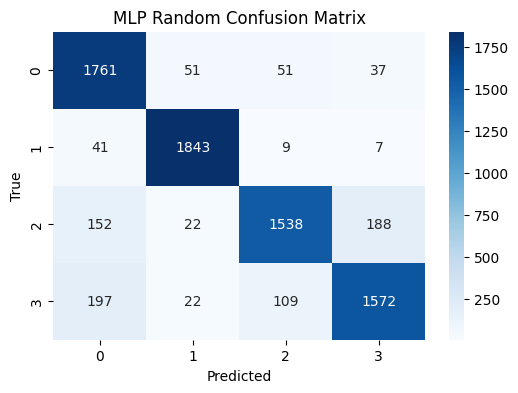

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


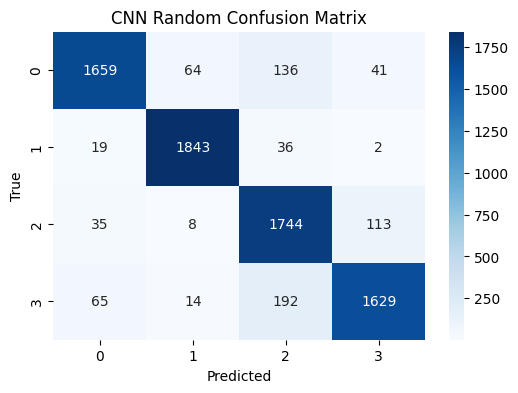

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


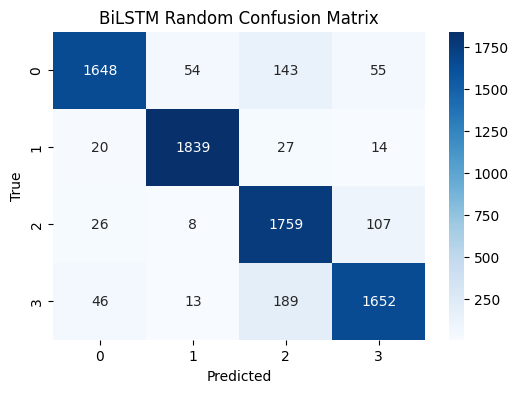

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


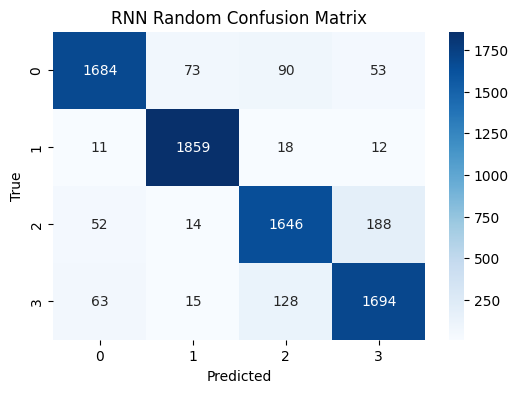

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


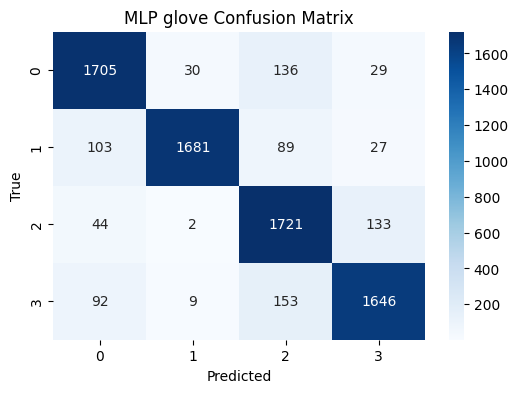

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


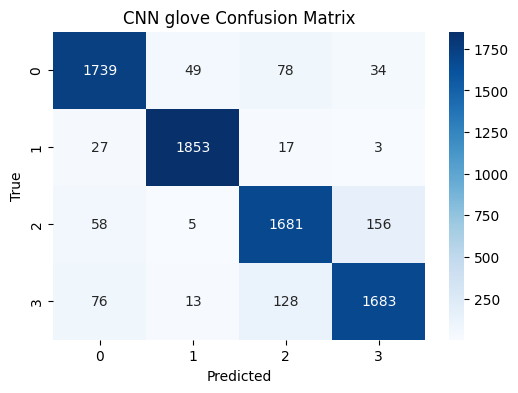

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


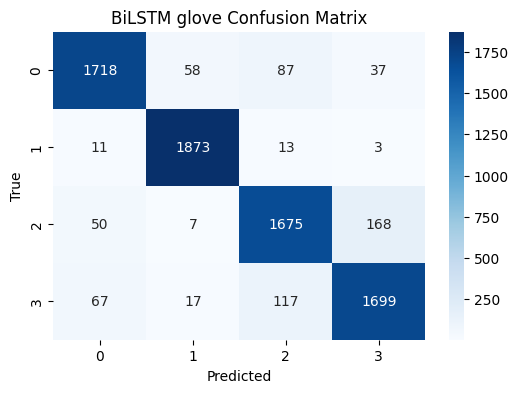

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


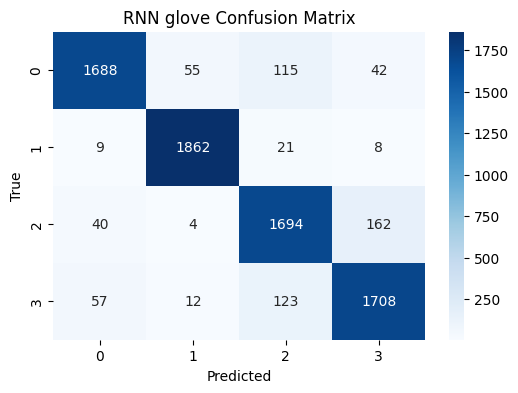

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


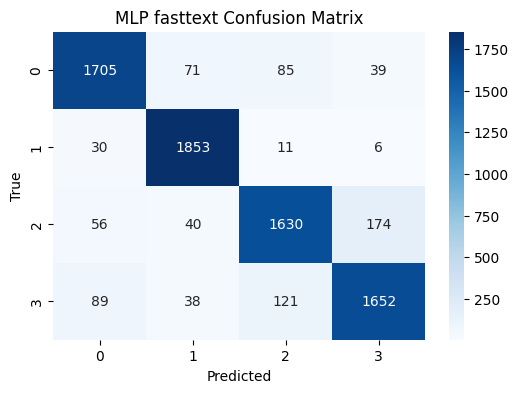

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


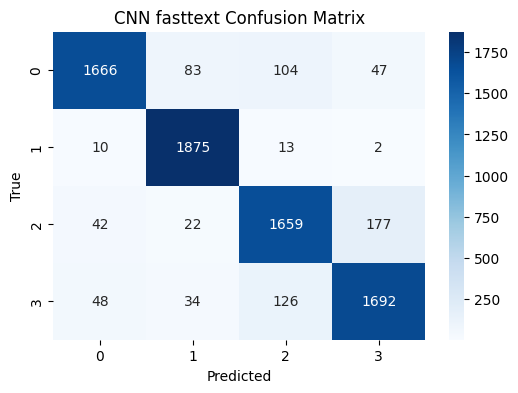

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


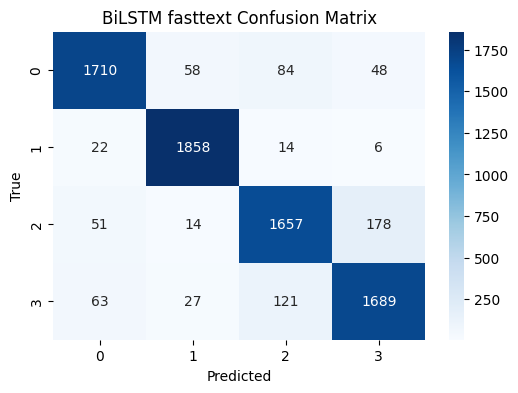

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


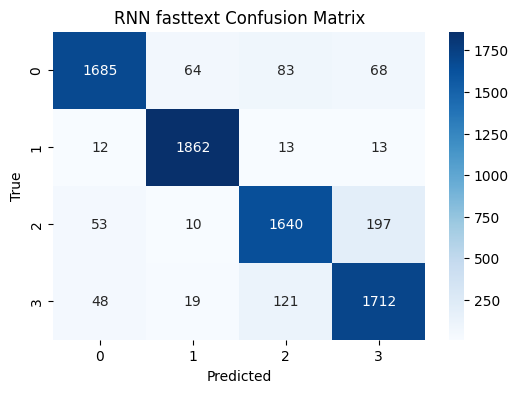

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


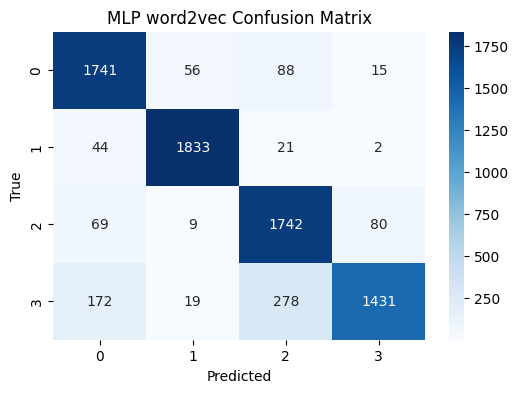

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


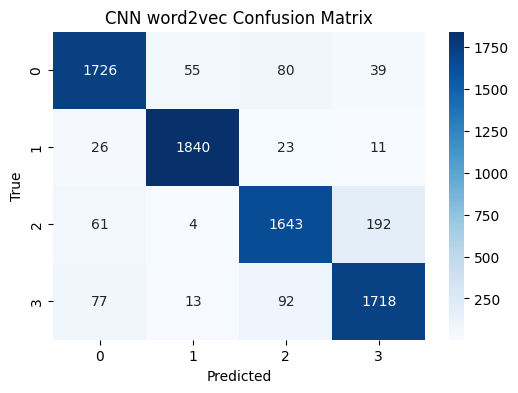

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


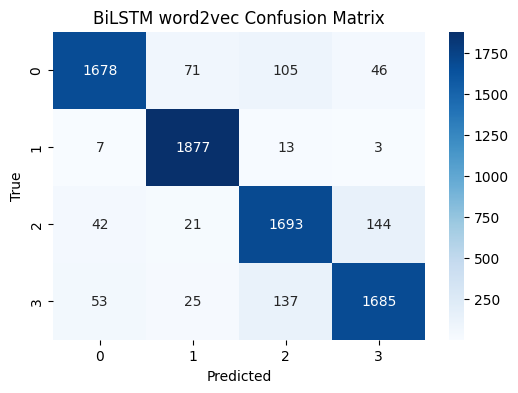

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


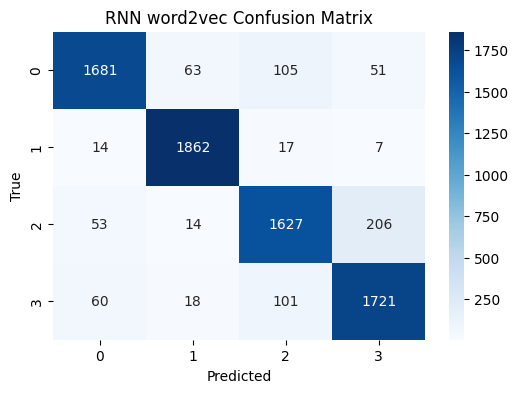

In [ ]:
plot_confusion(mlp_random, model_name="MLP Random")
plot_confusion(cnn_random, model_name="CNN Random")
plot_confusion(BiLstm_random , model_name="BiLSTM Random")
plot_confusion(rnn_random , model_name="RNN Random")
plot_confusion(mlp_glove, model_name="MLP glove")
plot_confusion(cnn_glove, model_name="CNN glove")
plot_confusion(BiLstm_glove , model_name="BiLSTM glove")
plot_confusion(rnn_glove , model_name="RNN glove")
plot_confusion(mlp_fasttext, model_name="MLP fasttext")
plot_confusion(cnn_fasttext, model_name="CNN fasttext")
plot_confusion(BiLstm_fasttext , model_name="BiLSTM fasttext")
plot_confusion(rnn_fasttext , model_name="RNN fasttext")
plot_confusion(mlp_word2vec, model_name="MLP word2vec")
plot_confusion(cnn_word2vec, model_name="CNN word2vec")
plot_confusion(BiLstm_word2vec , model_name="BiLSTM word2vec")
plot_confusion(rnn_word2vec , model_name="RNN word2vec")

### 7.2 Training History

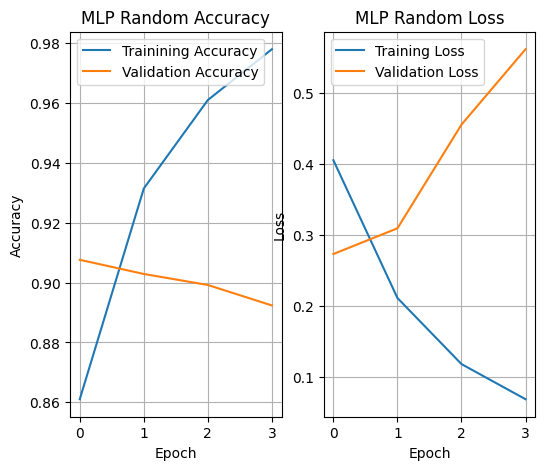

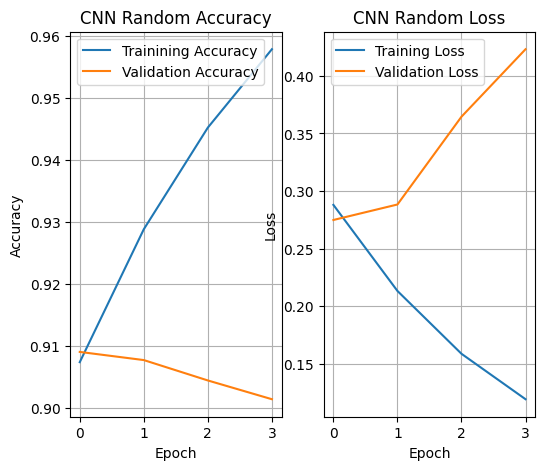

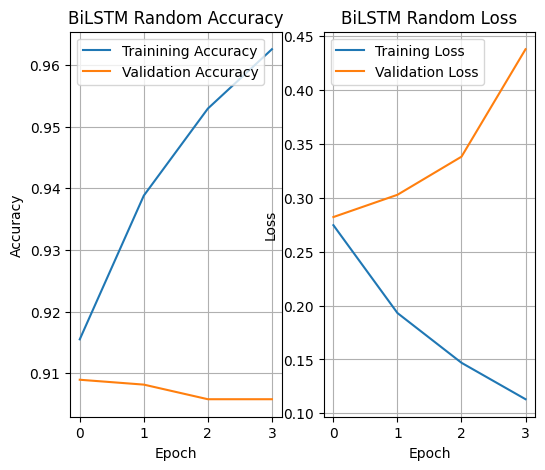

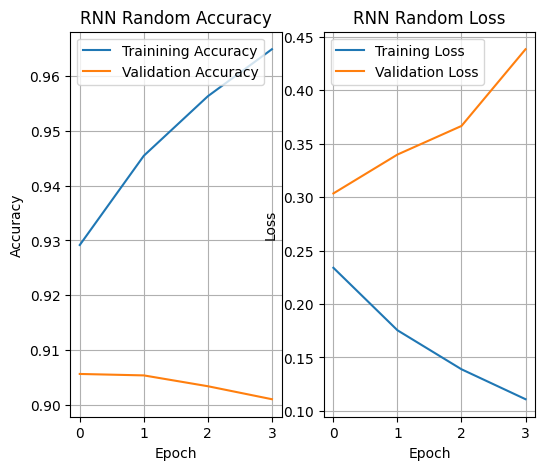

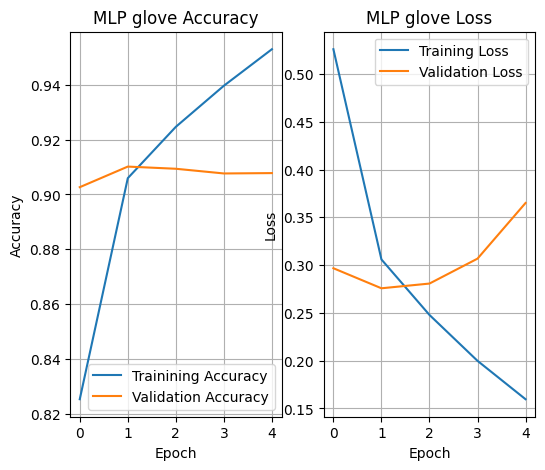

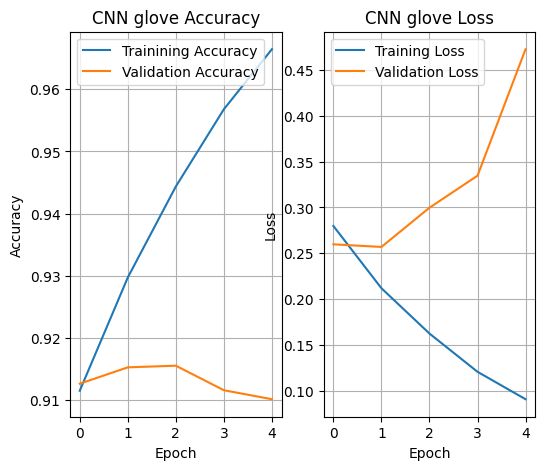

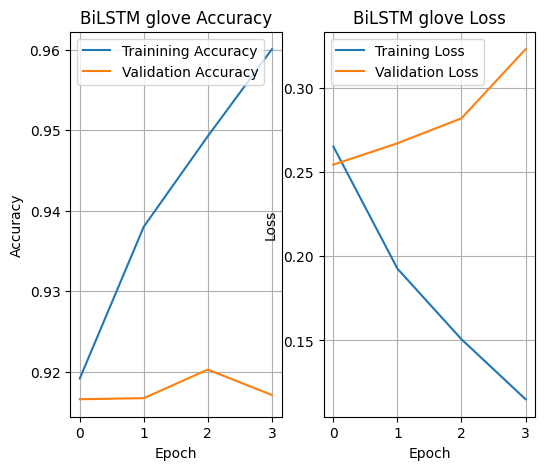

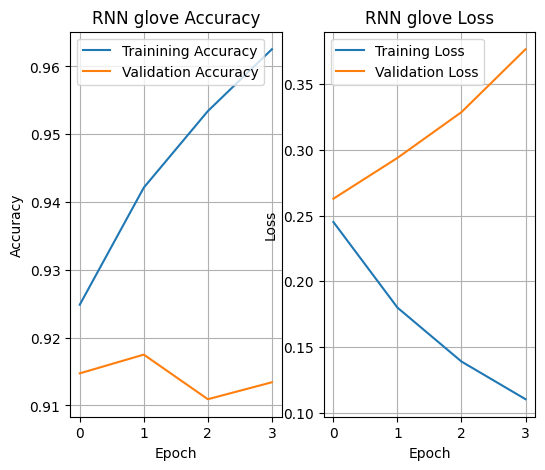

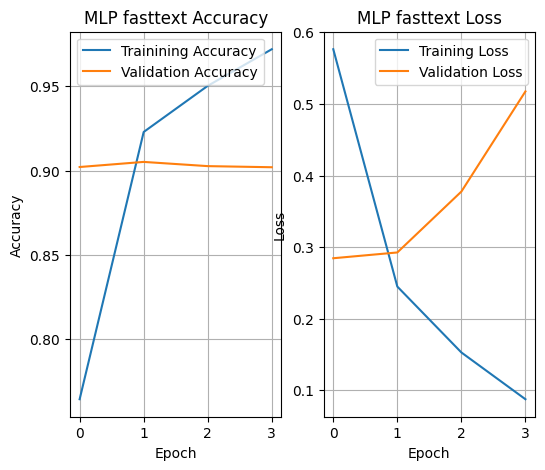

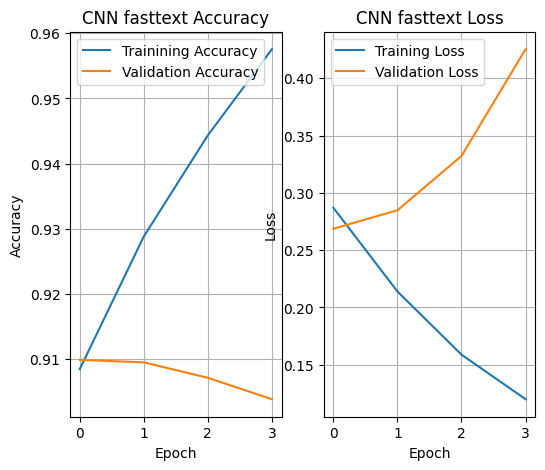

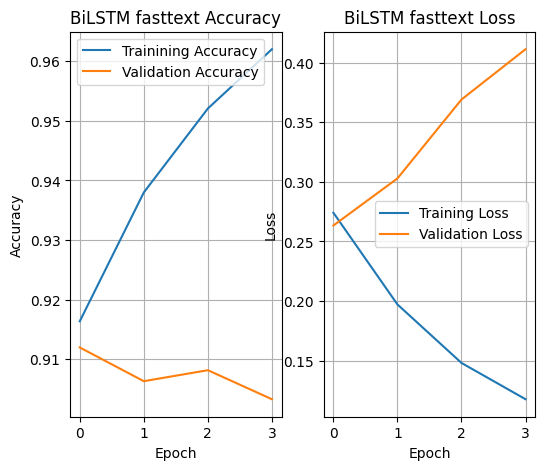

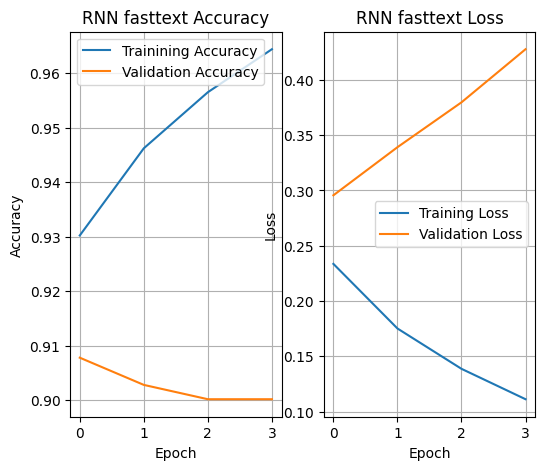

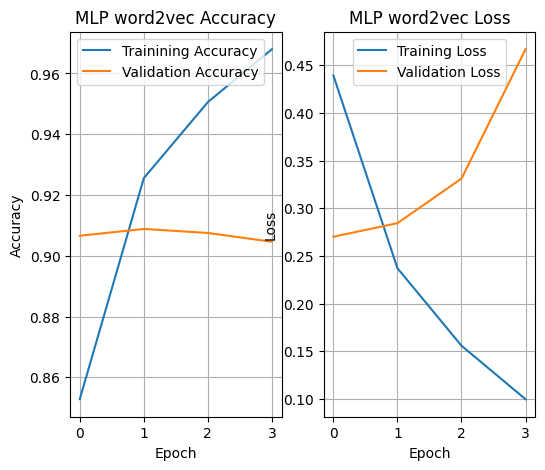

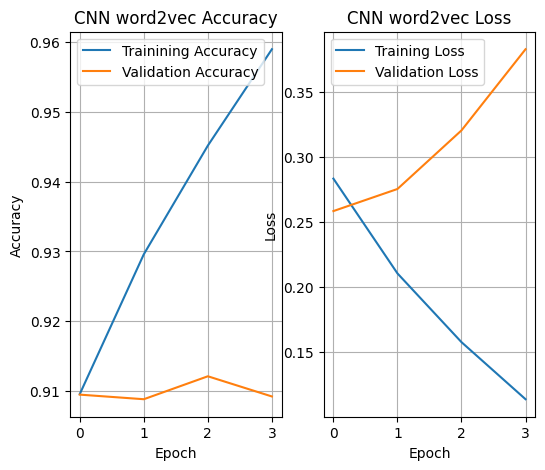

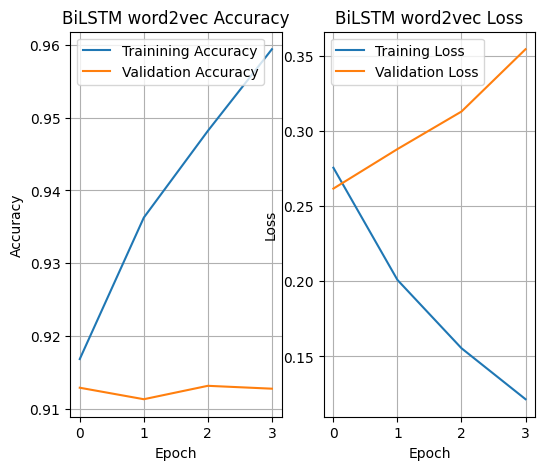

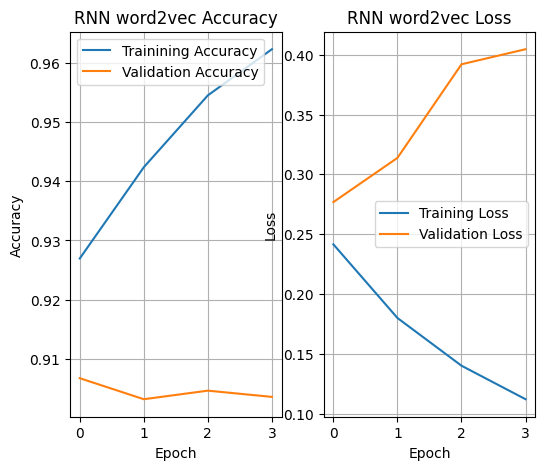

In [ ]:
plot_training_history(history_mlp_random, model_name="MLP Random")
plot_training_history(history_cnn_random, model_name="CNN Random")
plot_training_history(history_BiLstm_random , model_name="BiLSTM Random")
plot_training_history(history_rnn_random , model_name="RNN Random")
plot_training_history(history_mlp_glove, model_name="MLP glove")
plot_training_history(history_cnn_glove, model_name="CNN glove")
plot_training_history(history_BiLstm_glove , model_name="BiLSTM glove")
plot_training_history(history_rnn_glove , model_name="RNN glove")
plot_training_history(history_mlp_fasttext, model_name="MLP fasttext")
plot_training_history(history_cnn_fasttext, model_name="CNN fasttext")
plot_training_history(history_BiLstm_fasttext , model_name="BiLSTM fasttext")
plot_training_history(history_rnn_fasttext , model_name="RNN fasttext")
plot_training_history(history_mlp_word2vec, model_name="MLP word2vec")
plot_training_history(history_cnn_word2vec, model_name="CNN word2vec")
plot_training_history(history_BiLstm_word2vec , model_name="BiLSTM word2vec")
plot_training_history(history_rnn_word2vec , model_name="RNN word2vec")